In [3]:

import pandas as pd
import numpy as np
import os

# Assuming that the csv file is loaded into a pandas DataFrame named df

df = pd.read_csv('C:\\Users\\zzzl0\\Desktop\\predicting-and-avoiding-dog-barking-behaviour\\predicting-and-avoiding-dog-barking-behaviour\\predictions.csv')

# Extracting unique dog names from 'File_Name'
df['Dog_Name'] = df['File_Name'].apply(lambda x: x.split('_')[0])
unique_dogs = df['Dog_Name'].unique()

# Create output directory if it doesn't exist
output_dir = 'C:\\Users\\zzzl0\\Desktop\\predicting-and-avoiding-dog-barking-behaviour\\predicting-and-avoiding-dog-barking-behaviour\\output\\model2_audio_clips\\augment'
os.makedirs(output_dir, exist_ok=True)

for dog in unique_dogs:
    # Filtering rows corresponding to the current dog
    df_dog = df[df['Dog_Name'] == dog]

    # Initializing new DataFrame for storing augmented data
    df_aug = pd.DataFrame(columns=['sound_class_list', 'output', 'File_Name'])

    for idx, row in df_dog.iterrows():
        sound_class_list = row[:-2].tolist()  # Converting row into list and excluding the 'File_Name' and 'Dog_Name'
        sound_class_list = [x for x in sound_class_list if not np.isnan(x)]  # Removing NaNs
        
        # Generating all continuous subsets and their corresponding class
        for i in range(len(sound_class_list) - 1):  # Excluding the last sound in each row
            for j in range(i+1, len(sound_class_list)):
                fragment = sound_class_list[i:j]
                if j == len(sound_class_list) - 1:  # Marking interval as 'Y' if fragment contains the second-last sound
                    output = 'Y'
                else:
                    output = 'N'  # Otherwise, marking it as 'N'
                    
                # Appending new row to df_aug
                new_row = pd.DataFrame([{'sound_class_list': fragment, 'output': output, 'File_Name': row['File_Name']}])
                df_aug = pd.concat([df_aug, new_row], ignore_index=True)

    # Saving the augmented dataframe to a new CSV file
    df_aug.to_csv(os.path.join(output_dir, f'{dog}_predicted_augmented_data.csv'), index=False)


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import ast
import pandas as pd
import glob
from sklearn import metrics
from sklearn.model_selection import train_test_split

def train_model(df, model_name):
    # Convert the string representation of lists into actual lists
    df['sound_class_list'] = df['sound_class_list'].apply(ast.literal_eval)

    # Creating separate columns for each sound
    df_sound = pd.DataFrame(df['sound_class_list'].to_list(), columns=[f'Sound_{i+1}' for i in range(df['sound_class_list'].str.len().max())])
    
    # Joining the sounds dataframe with the original dataframe
    df = pd.concat([df_sound, df['output']], axis=1)
    
    # Converting 'output' into binary
    df['output'] = df['output'].map({'Y': 1, 'N': 0})
    
    # Defining X and y
    X = df.drop(columns=['output'])
    y = df['output']
    
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Filling NaNs with zeros
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    # Choose the model based on model_name
    if model_name == 'LogisticRegression':
            parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight':['balanced', None],
                          'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
            # Create a base model
            lr = LogisticRegression(max_iter=1000)
            model = GridSearchCV(lr, parameters, cv=5, verbose=0)
    elif model_name == 'DecisionTree':
        model = DecisionTreeClassifier()
    elif model_name == 'RandomForest':
        model = RandomForestClassifier()
    elif model_name == 'SVM':
        model = svm.SVC()
    elif model_name == 'NeuralNetwork':
        model = Sequential()
        model.add(Dense(12, input_dim=len(X_train.columns), activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        print("Invalid model name")
        return

    # Training the model
    if model_name == 'NeuralNetwork':
        model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
    else:
        model.fit(X_train, y_train)

    # Making predictions on the test set
    if model_name == 'NeuralNetwork':
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
    else:
        y_pred = model.predict(X_test)
    
    # Return the metrics of the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return accuracy, precision, recall, f1


c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

3/3 [==============================] - 0s 2ms/step


C:\Users\zzzl0\AppData\Local\Temp\ipykernel_3744\2867217527.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_metrics = results_df.groupby('Model').mean()


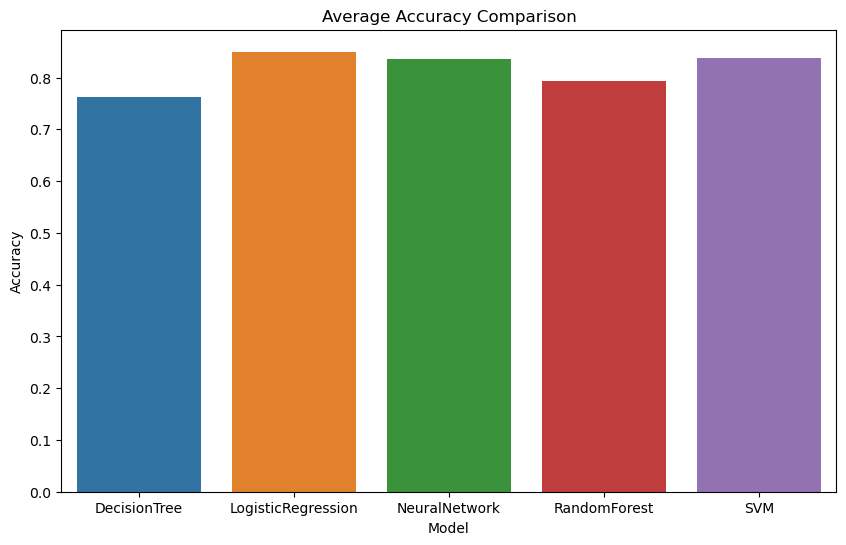

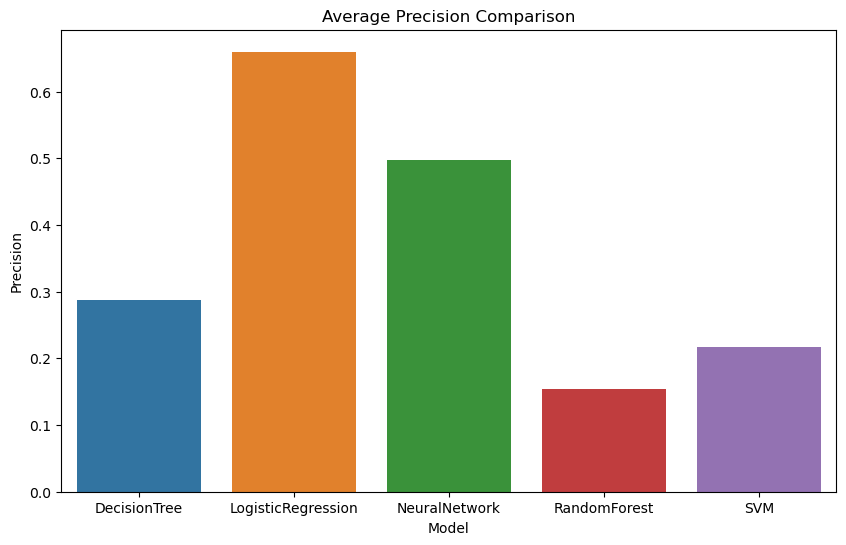

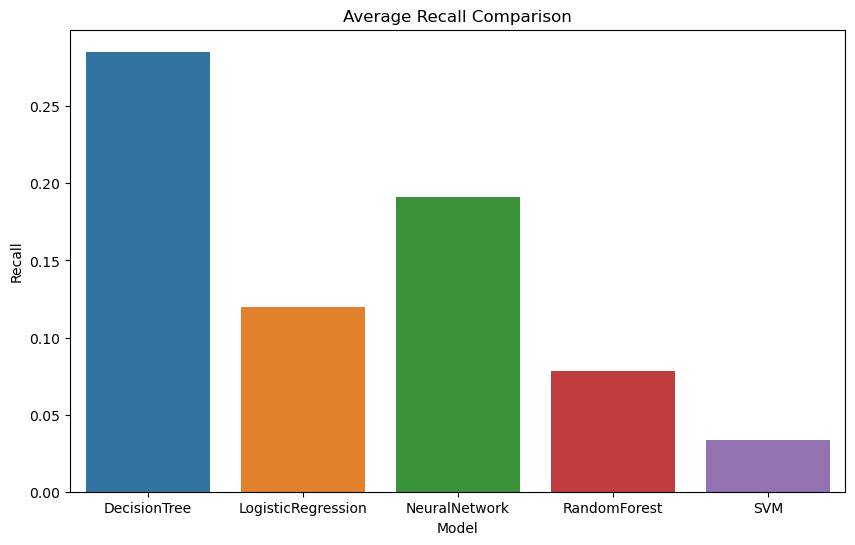

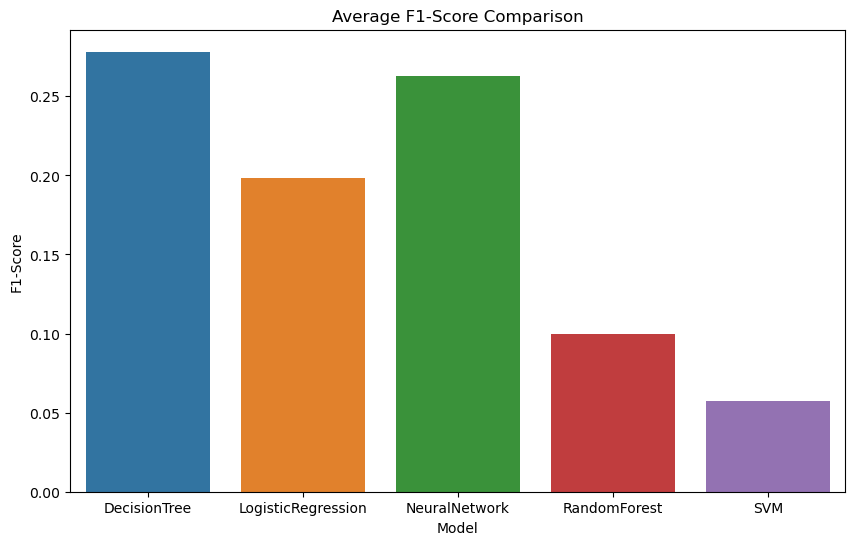

c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

3/3 [==============================] - 0s 2ms/step


c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zzzl0\AppData\Local\Temp\ipykernel_3744\2867217527.py:130: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_metrics = results_df.groupby('Model').mean()


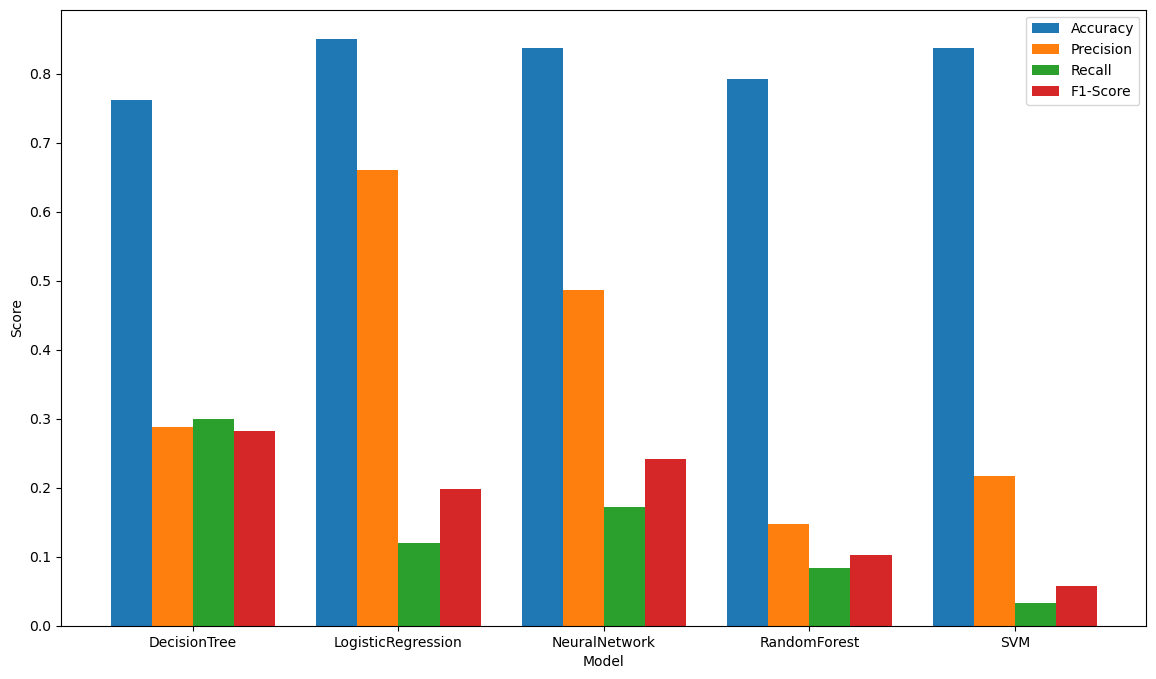

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import ast
import pandas as pd
import glob
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Define model names
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'SVM', 'NeuralNetwork']

# Define a dictionary to store results
results = {
    'Model': [],
    'Dog': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

import glob

# Define the directory containing the files
output_dir = 'C:\\Users\\zzzl0\\Desktop\\predicting-and-avoiding-dog-barking-behaviour\\predicting-and-avoiding-dog-barking-behaviour\\output\\model2_audio_clips\\augment'

# Use glob to get all .csv files in the directory
augmented_files = glob.glob(output_dir + "\\import matplotlib.pyplot as plt")
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import ast
import pandas as pd
import glob
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Define model names
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'SVM', 'NeuralNetwork']

# Define a dictionary to store results
results = {
    'Model': [],
    'Dog': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

import glob

# Define the directory containing the files
output_dir = 'C:\\Users\\zzzl0\\Desktop\\predicting-and-avoiding-dog-barking-behaviour\\predicting-and-avoiding-dog-barking-behaviour\\output\\model2_audio_clips\\augment'

# Use glob to get all .csv files in the directory
augmented_files = glob.glob(output_dir + "\\Dog*_predicted_augmented_data.csv")

# Now augmented_files is a list containing the filepaths of all .csv files in the directory

# Loop through each model
for model_name in model_names:
    # Loop through each augmented file
    for file in augmented_files:
        # Read the file into a dataframe
        df = pd.read_csv(file)
        
        # Train the model and get the metrics
        accuracy, precision, recall, f1 = train_model(df, model_name)
        
        # Add the metrics to the results dictionary
        results['Model'].append(model_name)
        results['Dog'].append(file)
        results['Accuracy'].append(accuracy)
        results['Precision'].append(precision)
        results['Recall'].append(recall)
        results['F1-Score'].append(f1)

# Convert the results dictionary into a dataframe
results_df = pd.DataFrame(results)

# Compute the average metrics for each model
average_metrics = results_df.groupby('Model').mean()

# Plot the average metrics for comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=average_metrics.index, y=average_metrics[metric])
    plt.title(f'Average {metric} Comparison')
    plt.ylabel(metric)
    plt.show()


# Now augmented_files is a list containing the filepaths of all .csv files in the directory

# Loop through each model
for model_name in model_names:
    # Loop through each augmented file
    for file in augmented_files:
        # Read the file into a dataframe
        df = pd.read_csv(file)
        
        # Train the model and get the metrics
        accuracy, precision, recall, f1 = train_model(df, model_name)
        
        # Add the metrics to the results dictionary
        results['Model'].append(model_name)
        results['Dog'].append(file)
        results['Accuracy'].append(accuracy)
        results['Precision'].append(precision)
        results['Recall'].append(recall)
        results['F1-Score'].append(f1)

# Convert the results dictionary into a dataframe
results_df = pd.DataFrame(results)

# Compute the average metrics for each model
average_metrics = results_df.groupby('Model').mean()
'''
# Plot the average metrics for comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=average_metrics.index, y=average_metrics[metric])
    plt.title(f'Average {metric} Comparison')
    plt.ylabel(metric)
    plt.show()'''


# Define the figure size
plt.figure(figsize=(14, 8))

# Define the number of models and the number of metrics
n_models = len(average_metrics.index)
n_metrics = len(metrics)

# Define the width of a bar and the locations of the groups and bars
bar_width = 0.2
group_locations = np.arange(n_models)
bar_locations = [group_locations + i*bar_width for i in range(n_metrics)]

# For each metric, make a bar plot
for i, metric in enumerate(metrics):
    plt.bar(bar_locations[i], average_metrics[metric], width=bar_width, label=metric)

# Set the x-ticks to be the middle of the groups
plt.xticks(group_locations + bar_width*(n_metrics-1) / 2, average_metrics.index)

# Add labels and a legend
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()

# Show the plot
plt.show()



In [22]:
# Convert the results dictionary into a dataframe
results_df = pd.DataFrame(results)

# Compute the average metrics for each model
average_metrics = results_df.groupby('Model').mean()

# Display the average_metrics dataframe
average_metrics = average_metrics.round(2)

print(average_metrics)
average_metrics.to_csv('average_metrics.csv')


C:\Users\zzzl0\AppData\Local\Temp\ipykernel_3744\1297506176.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_metrics = results_df.groupby('Model').mean()


                    Accuracy  Precision  Recall  F1-Score
Model                                                    
DecisionTree            0.76       0.26    0.28      0.26
LogisticRegression      0.85       0.66    0.12      0.20
NeuralNetwork           0.83       0.41    0.20      0.26
RandomForest            0.79       0.13    0.08      0.10
SVM                     0.84       0.22    0.03      0.06


PermissionError: [Errno 13] Permission denied: 'average_metrics.csv'

In [23]:
# Define a function that maps each dog to its group
def map_dog_to_group(dog_file):
    dog_number = int(dog_file.split('Dog')[1].split('_')[0])
    if dog_number <= 3:
        return '1-3'
    elif dog_number <= 6:
        return '4-6'
    else:
        return '7-10'

# Add a new 'Group' column to the dataframe
results_df['Group'] = results_df['Dog'].apply(map_dog_to_group)

# Compute the average accuracy for each model and group
average_accuracy_by_group = results_df.groupby(['Model', 'Group'])['Accuracy'].mean()

# Display the average accuracy by group
print(average_accuracy_by_group).round(3)
average_accuracy_by_group = average_accuracy_by_group.round(3)
average_accuracy_by_group.to_csv('rounded_results.csv')


Model               Group
DecisionTree        1-3      0.756884
                    4-6      0.792512
                    7-10     0.727536
LogisticRegression  1-3      0.873066
                    4-6      0.873505
                    7-10     0.815049
NeuralNetwork       1-3      0.855844
                    4-6      0.848008
                    7-10     0.799990
RandomForest        1-3      0.819040
                    4-6      0.807522
                    7-10     0.765386
SVM                 1-3      0.849637
                    4-6      0.878124
                    7-10     0.798481
Name: Accuracy, dtype: float64


AttributeError: 'NoneType' object has no attribute 'round'